# Household Electric Power Consumption Forecasting

## Introduction

Electric power consumption forecasting is essential for optimizing energy usage, managing supply and demand, and ensuring stability in power grids. In recent years, the growing need for efficient energy management, coupled with advancements in data science, has led to the adoption of predictive models for forecasting energy consumption. 

In this project, we aim to build a model that can forecast household electric power consumption using historical data. Our goal is to analyze this data and use time series forecasting techniques to predict future energy consumption.


## Outline:
1. Dataset Description
2. Data preparation
3. Exploratory Data Analysis (EDA)
4. Feature Engineering
5. Model Development
6. Model Evaluation
7. Conclusion

## 1.Dataset Description

This dataset contains electric power consumption measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months).
It consists of **2,075,259 observations** and **9 features**:

- **Date**: Date of measurement (dd/mm/yyyy).
- **Time**: Time of measurement (hh:mm:ss).
- **Global_active_power**: Average active power consumed (kilowatts).
- **Global_reactive_power**: Average reactive power consumed (kilowatts).
- **Voltage**: Average voltage (volts).
- **Global_intensity**: Average current intensity (amperes).
- **Sub_metering_1**: Energy usage in the kitchen (watt-hours).
- **Sub_metering_2**: Energy usage in the laundry room (watt-hours).
- **Sub_metering_3**: Energy usage for water heating and air conditioning (watt-hours).



## 2.Data preparation
In this section we will load the data and handle the missing values 

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from ray import tune
from ray import train 
from ray.tune.schedulers import ASHAScheduler
from joblib import dump, load

In [2]:
# consider 'nan' and '?' as NAN values and concate the date and time to set it as index
df = pd.read_csv('/kaggle/input/electric-power-consumption-data-set/household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

/tmp/ipykernel_30/4152897016.py:2: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv('/kaggle/input/electric-power-consumption-data-set/household_power_consumption.txt', sep=';',
/tmp/ipykernel_30/4152897016.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('/kaggle/input/electric-power-consumption-data-set/household_power_consumption.txt', sep=';',
/tmp/ipykernel_30/4152897016.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('/kaggle/input/electric-power-consumption-data-set/h

In [3]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [4]:
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

There are notible number of missing values for all features.Since it is time series problem we will use forward fill method to fill these values based on previous valid observations.

In [5]:
df.ffill(axis=0,inplace=True)
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

## 3.Exploratory Data Analysis (EDA)
To gain insights from data,we will do the time series analysis,explore the distruction of the features and the correction.

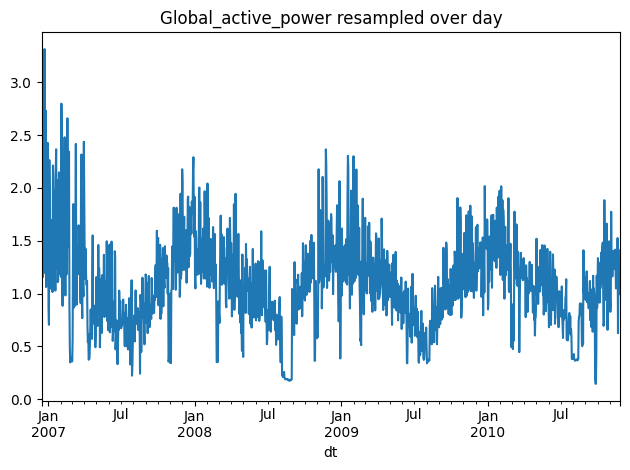

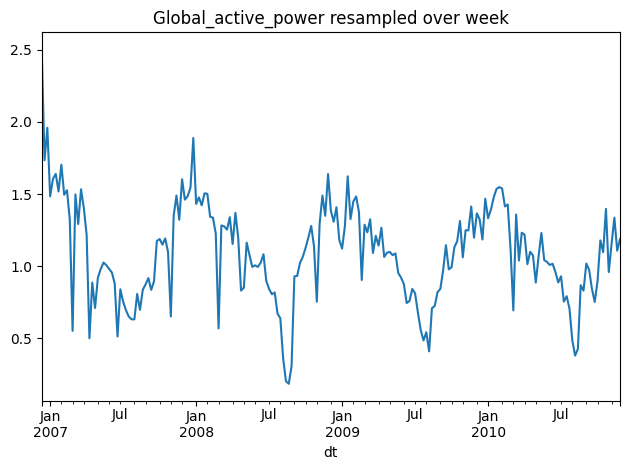

In [45]:
# plot the mean values over days, weeks months and quarter 
df.Global_active_power.resample('D').mean().plot(title='Global_active_power resampled over day')
plt.tight_layout()
plt.show()
df.Global_active_power.resample('W').mean().plot(title='Global_active_power resampled over week')
plt.tight_layout()
plt.show()

/tmp/ipykernel_30/1748157705.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.Global_active_power.resample('M').mean().plot(kind='bar',title='Global_active_power resampled over month')


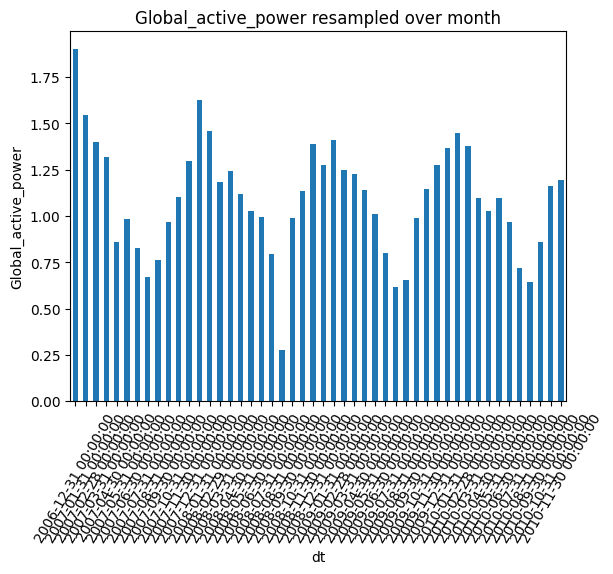

/tmp/ipykernel_30/1748157705.py:5: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df.Global_active_power.resample('Q').mean().plot(kind='bar',title='Global_active_power resampled over quarter')


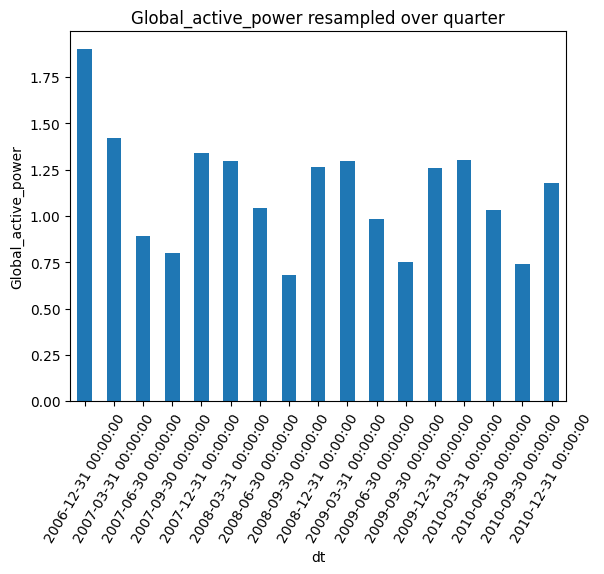

In [46]:
df.Global_active_power.resample('M').mean().plot(kind='bar',title='Global_active_power resampled over month')
plt.xticks(rotation=60)
plt.ylabel('Global_active_power')
plt.show()
df.Global_active_power.resample('Q').mean().plot(kind='bar',title='Global_active_power resampled over quarter')
plt.xticks(rotation=60)
plt.ylabel('Global_active_power')
plt.show()

We can see  that less power is consumed in June, July, August, September, whereas more power is consumed during December, January, February.

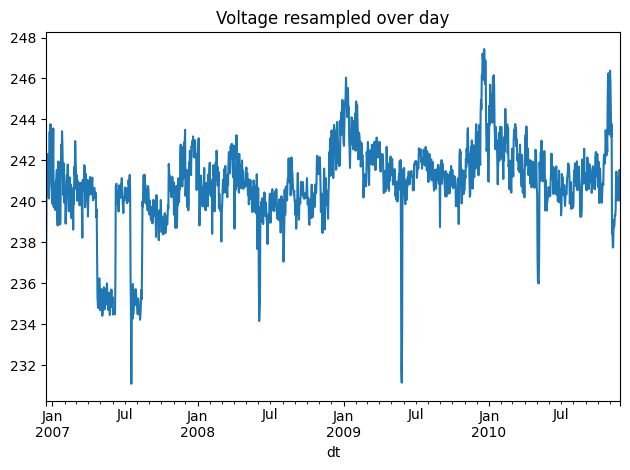

/tmp/ipykernel_30/3361870279.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df['Voltage'].resample('M').mean().plot(kind='bar', color='red')


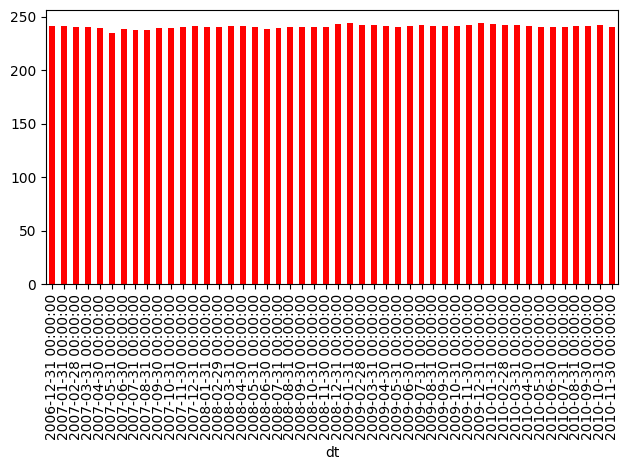

In [47]:
df.Voltage.resample('D').mean().plot(title='Voltage resampled over day')
plt.tight_layout()
plt.show()
df['Voltage'].resample('M').mean().plot(kind='bar', color='red')
plt.tight_layout()
plt.show()

The **Voltage** feature appears to be relatively constant over time, showing minimal fluctuations. Due to its stability

/tmp/ipykernel_30/128688938.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  axs[0, 0].hist(df.Global_active_power.resample('M').mean(), color='r', alpha=0.5)
/tmp/ipykernel_30/128688938.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  axs[0, 1].hist(df.Global_reactive_power.resample('M').mean(), color='b', alpha=0.5)
/tmp/ipykernel_30/128688938.py:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  axs[0, 2].hist(df.Global_intensity.resample('M').mean(), color='g', alpha=0.5)
/tmp/ipykernel_30/128688938.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  axs[1, 0].hist(df.Sub_metering_1.resample('M').mean(), color='y', alpha=0.5)
/tmp/ipykernel_30/128688938.py:31: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
 

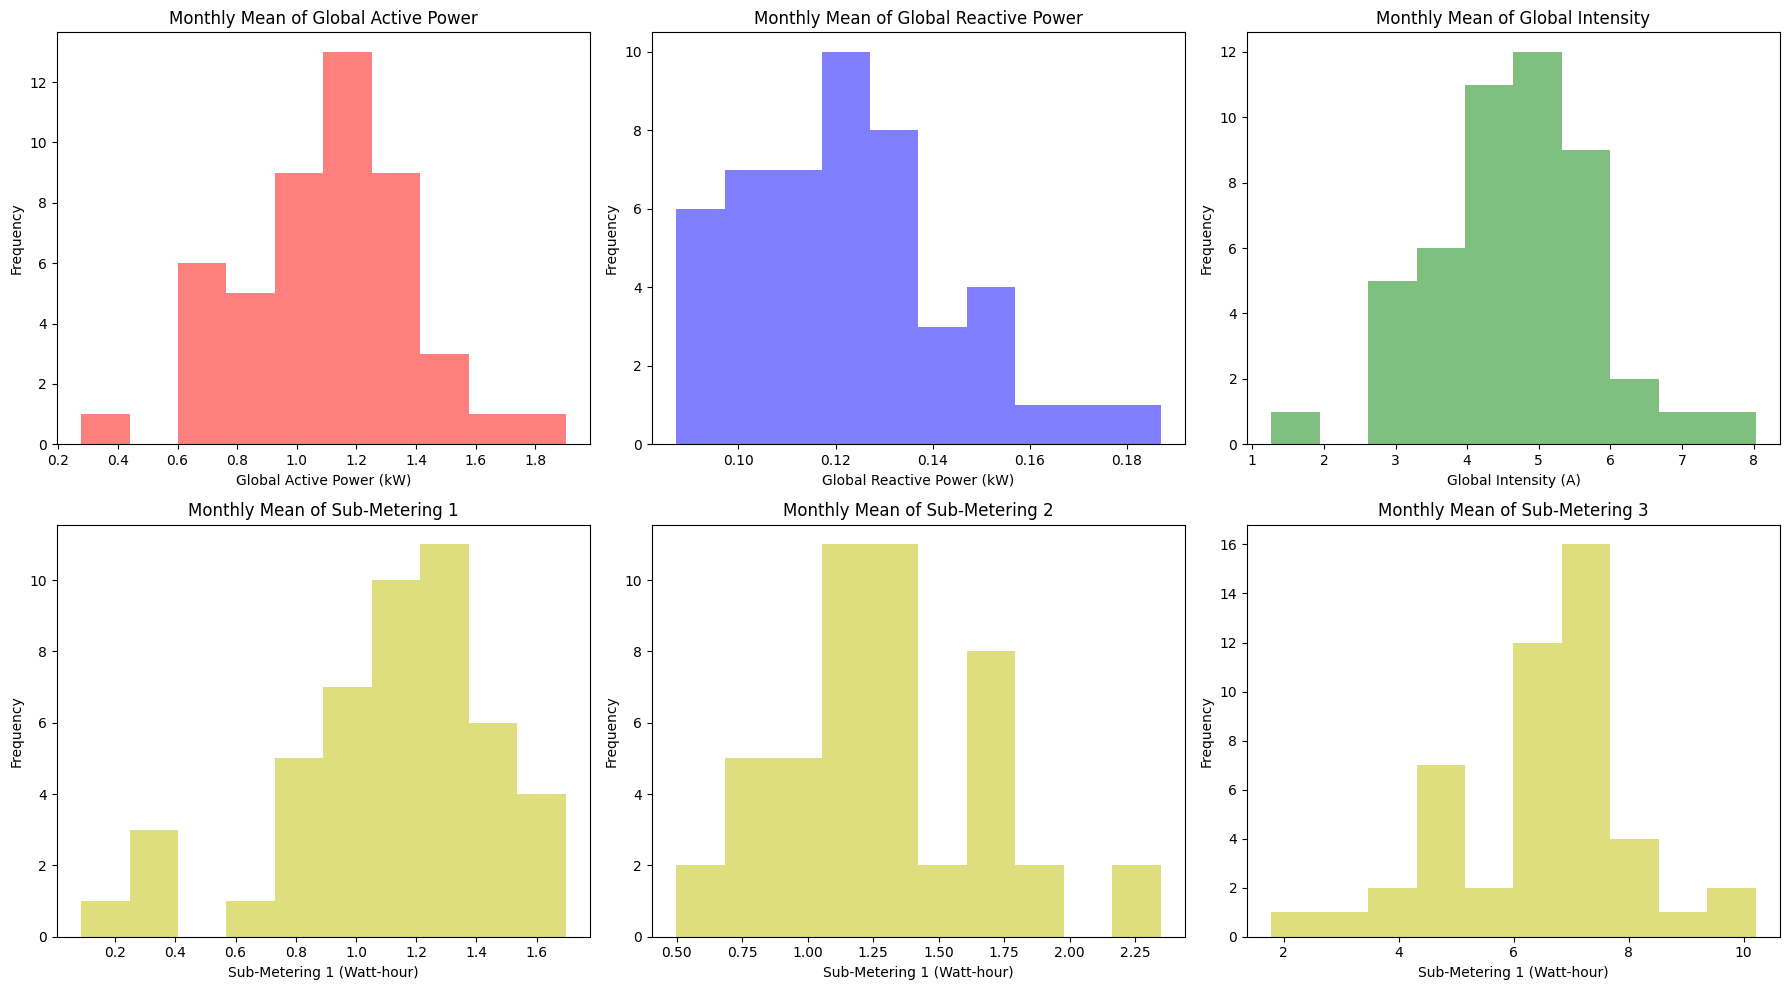

In [48]:
import matplotlib.pyplot as plt

# Create subplots with a 2x3 grid (2 rows, 3 columns)
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

# Plot Global Active Power histogram
axs[0, 0].hist(df.Global_active_power.resample('M').mean(), color='r', alpha=0.5)
axs[0, 0].set_title("Monthly Mean of Global Active Power")
axs[0, 0].set_xlabel("Global Active Power (kW)")
axs[0, 0].set_ylabel("Frequency")

# Plot Global Reactive Power histogram
axs[0, 1].hist(df.Global_reactive_power.resample('M').mean(), color='b', alpha=0.5)
axs[0, 1].set_title("Monthly Mean of Global Reactive Power")
axs[0, 1].set_xlabel("Global Reactive Power (kW)")
axs[0, 1].set_ylabel("Frequency")

# Plot Global Intensity histogram
axs[0, 2].hist(df.Global_intensity.resample('M').mean(), color='g', alpha=0.5)
axs[0, 2].set_title("Monthly Mean of Global Intensity")
axs[0, 2].set_xlabel("Global Intensity (A)")
axs[0, 2].set_ylabel("Frequency")

# Plot Sub_metering_1 histogram
axs[1, 0].hist(df.Sub_metering_1.resample('M').mean(), color='y', alpha=0.5)
axs[1, 0].set_title("Monthly Mean of Sub-Metering 1")
axs[1, 0].set_xlabel("Sub-Metering 1 (Watt-hour)")
axs[1, 0].set_ylabel("Frequency")

# Plot Sub_metering_2 histogram
axs[1, 1].hist(df.Sub_metering_2.resample('M').mean(), color='y', alpha=0.5)
axs[1, 1].set_title("Monthly Mean of Sub-Metering 2")
axs[1, 1].set_xlabel("Sub-Metering 1 (Watt-hour)")
axs[1, 1].set_ylabel("Frequency")

# Plot Sub_metering_3 histogram
axs[1, 2].hist(df.Sub_metering_3.resample('M').mean(), color='y', alpha=0.5)
axs[1, 2].set_title("Monthly Mean of Sub-Metering 3")
axs[1, 2].set_xlabel("Sub-Metering 1 (Watt-hour)")
axs[1, 2].set_ylabel("Frequency")

# Adjust layout
plt.tight_layout()
plt.show()



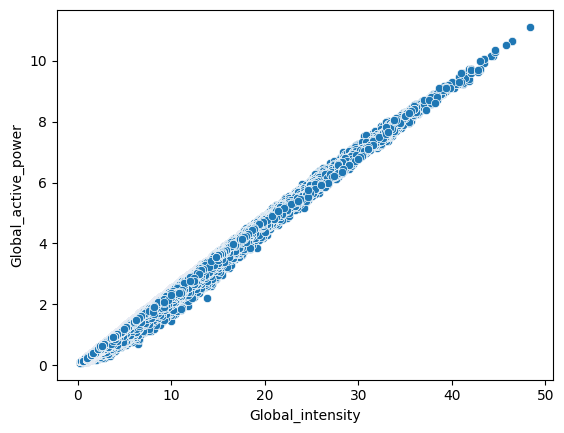

In [49]:
## The correlations between  'Global_active_power' and 'Global_intensity' and 'Voltage'
sns.scatterplot(x=df['Global_intensity'],y=df['Global_active_power']);


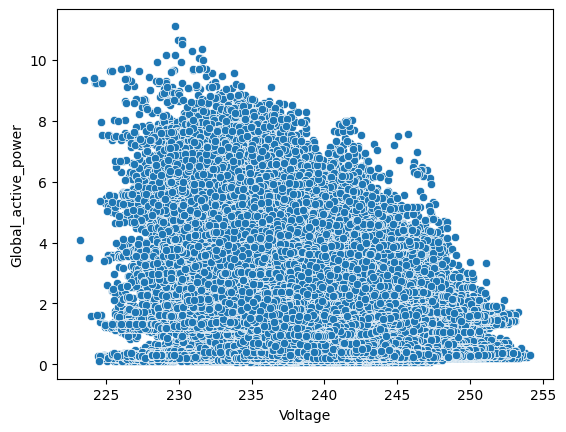

In [50]:
## The correlations between  'Global_active_power' and 'Voltage'
sns.scatterplot(x=df['Voltage'],y=df['Global_active_power']);

<Axes: >

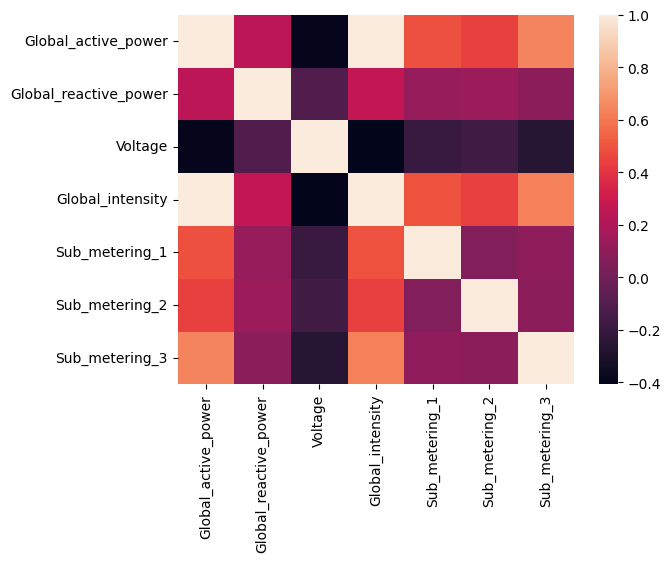

In [51]:
sns.heatmap(df.corr())

From above plots and the heatmap it is seen that 'Global_intensity' and the power mesurements are strongly correlated,but there no corretion with votlage since it is mostly stable within a range.

### 4.Feature Engineering

In this section, we create new features to improve the model:

1. **Power_Sub_Diff**:  Represents the difference between global active power and the sum of sub-metering values, capturing unmeasured energy consumption.
2. **Cyclical Time Features**:
    We transform the Hour, Minute, Day of Year, and Month into sine and cosine features to handle their cyclical nature. This helps the model learn      time-dependent patterns more effectively.

In [6]:
df['Power_Sub_Diff'] = df['Global_active_power'] - (df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3'])

In [7]:
hours = df.index.hour
days = df.index.dayofyear
months = df.index.month

# Hour of the day
df['sin_Hour'] = np.sin(2 * np.pi * hours / 24)
df['cos_Hour'] = np.cos(2 * np.pi * hours / 24)

# Day of the year
df['sin_Day'] = np.sin(2 * np.pi * days / 365)
df['cos_Day'] = np.cos(2 * np.pi * days / 365)

# Month of the year
df['sin_Month'] = np.sin(2 * np.pi * months / 12)
df['cos_Month'] = np.cos(2 * np.pi * months / 12)

In [8]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Power_Sub_Diff,sin_Hour,cos_Hour,sin_Day,cos_Day,sin_Month,cos_Month
dt,,,,,,,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,-13.784,-0.965926,-0.258819,-0.255353,0.966848,-2.449294e-16,1.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,-11.640,-0.965926,-0.258819,-0.255353,0.966848,-2.449294e-16,1.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,-13.626,-0.965926,-0.258819,-0.255353,0.966848,-2.449294e-16,1.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,-12.612,-0.965926,-0.258819,-0.255353,0.966848,-2.449294e-16,1.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,-14.334,-0.965926,-0.258819,-0.255353,0.966848,-2.449294e-16,1.0


## 4. Model Development
In this section, we will train both machine learning and deep learning models to forecast household electric power consumption. We will start with machine learning models like Random Forest and Gradient Boosting, and then explore deep learning models such as LSTM and tune it.

### Transform DataFrame to Feature and Label Arrays

In this step, we use the `df_to_X_y` function to convert our time series data into input-output pairs for training. The function takes a rolling window of a specified size (e.g., 5) as the feature sequence (`X`) and sets the next time step's target value as the label (`y`). This structure is useful for time series forecasting models that learn from past data to predict future values.


In [9]:
import numpy as np

def df_to_X_y(df, window_size=5):
    """
    Converts a DataFrame into feature (X) and label (y) arrays for time series forecasting.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame with time series data; the first column is the target.
        window_size (int): Number of time steps in each input sequence (default is 5).
    
    Returns:
        np.array: 3D array of shape (num_samples, window_size, num_features) for features (X).
        np.array: 1D array of shape (num_samples,) for labels (y), where each label is the target 
                  value immediately following each input sequence.
    """
    df_as_np = df.to_numpy()
    X, y = [], []
    for i in range(len(df_as_np) - window_size):
        X.append(df_as_np[i:i + window_size])
        y.append(df_as_np[i + window_size][0])  # First column is the target
    return np.array(X), np.array(y)


We resample the data to an hourly frequency, using the mean of each hour, to forecast power consumption on an hourly basis instead of each minute.

In [10]:
hour_df = df.resample('H').mean()

/tmp/ipykernel_30/981946171.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hour_df = df.resample('H').mean()


In [11]:
def prepare_data(window_size):
    """
    Prepares data for machine learning by:
    1. Converting the resampled DataFrame into feature and label arrays using `df_to_X_y`.
    2. Reshaping the features for model input.
    3. Splitting the data into training, validation, and test sets.
    
    Parameters:
        window_size (int): The size of the rolling window used to create sequences.
    
    Returns:
        X_train, y_train, X_val, y_val, X_test, y_test: Feature and label arrays split into 
        training, validation, and test sets.
    """
    X, y = df_to_X_y(hour_df, window_size)  # Convert DataFrame to features and labels
    X_ml = X.reshape(X.shape[0], X.shape[1] * X.shape[2])  # Reshape for ML models
    
    # Define split sizes
    train_size = 25000
    val_size = 5000  # Adjust as needed
    
    # Split into train, validation, and test sets
    X_train, y_train = X_ml[:train_size], y[:train_size]
    X_val, y_val = X_ml[train_size:train_size + val_size], y[train_size:train_size + val_size]
    X_test, y_test = X_ml[train_size + val_size:], y[train_size + val_size:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test



In [36]:
X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(5)

We train both Random Forest (RF) and Gradient Boosting (GB) models, then select the best-performing one based on evaluation metrics.


In [12]:
# Initialize the models
rf_model = RandomForestRegressor(random_state=42)
gb_model = GradientBoostingRegressor(random_state=42)

# Train the Random Forest model
rf_model.fit(X_train, y_train)

# Train the Gradient Boosting model
gb_model.fit(X_train, y_train)

# Predict on training and validation sets for both models
y_train_pred_rf = rf_model.predict(X_train)
y_val_pred_rf = rf_model.predict(X_val)

y_train_pred_gb = gb_model.predict(X_train)
y_val_pred_gb = gb_model.predict(X_val)

# Calculate Mean Squared Error for both models
mse_train_rf = mean_squared_error(y_train, y_train_pred_rf)
mse_val_rf = mean_squared_error(y_val, y_val_pred_rf)

mse_train_gb = mean_squared_error(y_train, y_train_pred_gb)
mse_val_gb = mean_squared_error(y_val, y_val_pred_gb)

# Print results
print("Random Forest MSE - Train:", mse_train_rf)
print("Random Forest MSE - Validation:", mse_val_rf)
print("Gradient Boosting MSE - Train:", mse_train_gb)
print("Gradient Boosting MSE - Validation:", mse_val_gb)


Random Forest MSE - Train: 0.03969672701440056
Random Forest MSE - Validation: 0.2786314375660936
Gradient Boosting MSE - Train: 0.2607738481757289
Gradient Boosting MSE - Validation: 0.26662363490597224


It's clear that Gradient Boosting has less validation loss and does not overfit.Therefore, we will tune it with diffent hyparameters like window_size,lr,n_estimators and max_depth.

In [13]:
errors = []
window_sizes = [5,10,15,20]
for w in window_sizes:
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(w)
    gb_model = GradientBoostingRegressor(random_state=42)
    gb_model.fit(X_train, y_train)
    y_val_pred_gb = gb_model.predict(X_val)
    mse_val_gb = mean_squared_error(y_val, y_val_pred_gb)
    errors.append({'window':w,'val_error':mse_val_gb})
    

In [14]:
err_df = pd.DataFrame(errors)
err_df

,window,val_error
0,5,0.266624
1,10,0.264344
2,15,0.262540
3,20,0.265464


In [18]:
X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(5)
param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7]
}
gb_model = GradientBoostingRegressor(random_state=42)

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=3, scoring="neg_mean_squared_error", n_jobs=-1, verbose=2)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best model and parameters
best_gb_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluate the best model on the validation set
y_val_pred = best_gb_model.predict(X_val)
mse_val = mean_squared_error(y_val, y_val_pred)

# Print results
print("Best Parameters:", best_params)
print("Validation MSE for Best Model:", mse_val)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Validation MSE for Best Model: 0.26151710763709574
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=  35.4s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time= 1.2min
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=  57.1s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=  57.1s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=300; total time= 2.9min
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=100; total time= 1.3min
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=200; total time= 2.7min
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=300; total time= 4.1min
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=  58.9s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=  57.5s
[

Now we will tune a LSTM model with different configurations using raytune, but we need to preserve the shape of X and normalize it.

In [25]:
def prepare_data_dl(window_size):
    # Convert DataFrame to features and target arrays
    X, y = df_to_X_y(hour_df, window_size)
    
    # Define train, validation, and test split indices
    train_size = 25000
    val_size = 5000  # example size, adjust as needed
    
    # Split data into train, val, and test sets
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
    X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [26]:
X_train, y_train, X_val, y_val, X_test_dl, y_test_dl = prepare_data_dl(5)
n_features = X_train.shape[2]
scaler = MinMaxScaler(feature_range=(0, 1))
# Reshape to 2D for scaling, then scale and reshape back to 3D
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, n_features)).reshape(X_train.shape)
X_val_scaled = scaler.transform(X_val.reshape(-1, n_features)).reshape(X_val.shape)

# Verify the shape is now compatible for LSTM (samples, timesteps, features)
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_val_scaled shape:", X_val_scaled.shape)

X_train_scaled shape: (25000, 5, 14)
X_val_scaled shape: (5000, 5, 14)


In [27]:
# define the search space
search_space = {
    'lr': tune.sample_from(lambda spec: 10 ** (-10 * np.random.uniform(0, 0.5))),
    'h': tune.choice([32, 64, 128, 256]),          # Number of LSTM units
    'n_layers': tune.choice([2, 3]),               # Number of LSTM layers
    'dropout': tune.choice([0, 0.2, 0.3, 0.5]),   # Dropout rate
    'b': tune.choice([32, 64]),                    # Batch size
    'seq_len': tune.sample_from(lambda spec: np.random.randint(7, 30)),  # Sequence length
    'dense_units': tune.choice([32, 64, 128]),     # Units for the Dense layer with ReLU
    'dense_activation': tune.choice(['relu', 'tanh'])  # Activation for Dense layer
}

In [28]:
def train_lstm(config, X_train, y_train, X_val, y_val):
    """
    Trains an LSTM model for time series forecasting.

    Parameters:
        config (dict): Dictionary of hyperparameters for the model, including:
            - 'lr': Learning rate
            - 'h': Number of hidden units in LSTM layers
            - 'n_layers': Number of LSTM layers
            - 'dropout': Dropout rate
            - 'b': Batch size
            - 'dense_units': Units for the Dense layer
            - 'dense_activation': Activation function for the Dense layer
        X_train (np.array): Training feature set.
        y_train (np.array): Training labels.
        X_val (np.array): Validation feature set.
        y_val (np.array): Validation labels.

    Returns:
        None: The function trains the model and reports validation loss (MSE).

    The function builds and trains an LSTM model with configurable layers, dropout, and dense units, 
    then reports the validation mean squared error (MSE).
    """
    # Unpack parameters
    lr = config['lr']
    hidden_units = config['h']
    n_layers = config['n_layers']
    dropout = config['dropout']
    batch_size = config['b']
    dense_units = config['dense_units']
    dense_activation = config['dense_activation']

    window_size = 5
    input_shape = (window_size, X_train.shape[2])
    
    # Build the model
    model = Sequential()

    # Add LSTM layers
    for i in range(n_layers):
        model.add(LSTM(hidden_units, return_sequences=(i < n_layers - 1), input_shape=input_shape))
        if dropout > 0:
            model.add(Dropout(dropout))

    # Add Dense layer with specified units and activation function
    model.add(Dense(dense_units, activation=dense_activation))

    # Final output layer for regression
    model.add(Dense(1))

    # Compile model
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=10,  # Use fewer epochs for tuning; increase for final training
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        verbose=0
    ) 

    # Evaluate and report validation MSE
    val_preds = model.predict(X_val)
    val_mse = mean_squared_error(y_val, val_preds)
    train.report({
        'val_mse': val_mse
    })


In [29]:
#Define the scheduler
scheduler = ASHAScheduler(
    metric="val_mse",
    mode="min",
    max_t=50,
    grace_period=5,
    reduction_factor=2
)

In [30]:
# Run Ray Tune
analysis = tune.run(
    tune.with_parameters(train_lstm, X_train=X_train_scaled, y_train=y_train, X_val=X_val_scaled, y_val=y_val),
    config=search_space,
    scheduler=scheduler,
    num_samples=10  # Adjust this based on your computation power
)


2024-11-07 10:11:45,128	INFO worker.py:1753 -- Started a local Ray instance.
2024-11-07 10:11:46,688	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2024-11-07 10:11:46,695	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


(train_lstm pid=445) /opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(train_lstm pid=445)   super().__init__(**kwargs)


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time= 1.2min
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=300; total time= 1.7min
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=200; total time= 1.9min
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=300; total time= 2.9min
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=200; total time= 2.7min
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=300; total time= 4.1min
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=300; total time= 1.8min
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time= 2.0min
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=300; total time= 3.0min
[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=200; total time= 2.7min
[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=300; total time= 4.1min
[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=100; total time= 1.0min
[CV] END ...learning_rate=0.

Trial name,val_mse
train_lstm_b22d9_00000,0.790396
train_lstm_b22d9_00001,0.492825
train_lstm_b22d9_00002,0.807026
train_lstm_b22d9_00003,0.279539
train_lstm_b22d9_00004,0.291536
train_lstm_b22d9_00005,0.32127
train_lstm_b22d9_00006,0.295124
train_lstm_b22d9_00007,0.77196
train_lstm_b22d9_00008,0.360635
train_lstm_b22d9_00009,1.16098


(train_lstm pid=1064) /opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead. [repeated 4x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(train_lstm pid=1064)   super().__init__(**kwargs) [repeated 4x across cluster]


  1/157 ━━━━━━━━━━━━━━━━━━━━ 2:14 861ms/step
 18/157 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
 35/157 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
 52/157 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
 69/157 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
 85/157 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
102/157 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
117/157 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
136/157 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
153/157 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
  1/157 ━━━━━━━━━━━━━━━━━━━━ 1:41 649ms/step
 25/157 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
 47/157 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 70/157 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 94/157 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
111/157 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
132/157 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


(train_lstm pid=1370) /opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(train_lstm pid=1370)   super().__init__(**kwargs)
(train_lstm pid=1481) /opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(train_lstm pid=1481)   super().__init__(**kwargs)


  1/157 ━━━━━━━━━━━━━━━━━━━━ 2:45 1s/step
  4/157 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
 11/157 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
 19/157 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
 27/157 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
 35/157 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
 43/157 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
 47/157 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
 55/157 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
 63/157 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
 71/157 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
 79/157 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
 86/157 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
 94/157 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
103/157 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
107/157 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
116/157 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
124/157 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
133/157 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
139/157 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
145/157 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
148/157 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
152/157 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 15

(train_lstm pid=1790) /opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(train_lstm pid=1790)   super().__init__(**kwargs)
(train_lstm pid=1854) /opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(train_lstm pid=1854)   super().__init__(**kwargs)


  1/157 ━━━━━━━━━━━━━━━━━━━━ 2:37 1s/step
 21/157 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 42/157 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 60/157 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 81/157 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 99/157 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
119/157 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
139/157 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
149/157 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


(train_lstm pid=2276) /opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
(train_lstm pid=2276)   super().__init__(**kwargs)


  1/157 ━━━━━━━━━━━━━━━━━━━━ 1:49 702ms/step
  8/157 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
 16/157 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
 24/157 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
 32/157 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
 40/157 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
 48/157 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
 56/157 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
 64/157 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
 72/157 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
 79/157 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
 85/157 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
 93/157 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
 98/157 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
102/157 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
111/157 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
113/157 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
118/157 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
121/157 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
128/157 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
133/157 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
139/157 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
146/157 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
149/157 ━━━━━━━━━━━━━━━━━━━━ 0s

2024-11-07 10:22:45,982	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_lstm_2024-11-07_10-11-46' in 0.0089s.
2024-11-07 10:22:45,995	INFO tune.py:1041 -- Total run time: 659.30 seconds (643.81 seconds for the tuning loop).


Since the best gb_model is simpler and has a less MSE, we will save it for deploymemt

## 6.Model Evaluation
In the last setion we evaluate the best model on the test data and plot the predictions

In [37]:
# Evaluate the best model on the validation set
y_test_pred = best_gb_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)

print("Test MSE for Best Model:", mse_test)

Test MSE for Best Model: 0.1931680226076006


In [44]:
def plot_predictions(model,X,y,start=0,end=100):
    plt.figure(figsize=(12,6))
    predictions = model.predict(X).flatten()
    df = pd.DataFrame(data={'Original': y.flatten(), 'Predicted': predictions})
    plt.plot(df['Original'][start:end], label='Original', color='tab:blue')
    plt.plot(df['Predicted'][start:end], label='Predicted', color='tab:orange')
    plt.legend(loc='best')
    plt.show()

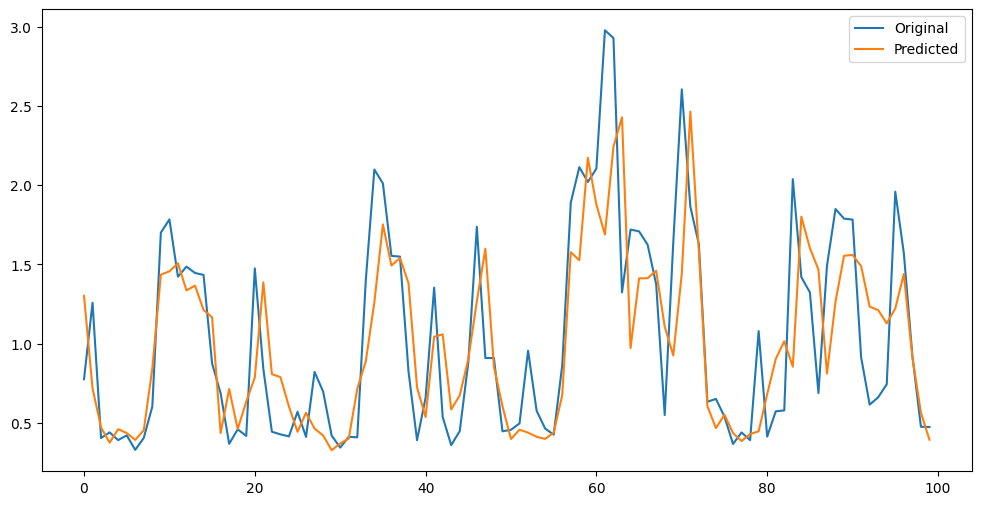

In [45]:
plot_predictions(best_gb_model,X_test,y_test)

In [ ]:
# model saving 
import pickle

# Save the model
with open('model.pkl', 'wb') as file:
    pickle.dump(best_gb_model, file)

## 7.Conclusion

In this project, we successfully forecasted electricity consumption using the Household Power Consumption dataset. After thorough data preparation, exploratory analysis, and feature engineering, we developed and evaluated multiple models. The Gradient Boosting model outperformed others, achieving the best performance with the parameters: `learning_rate = 0.1`, `max_depth = 5`, and `n_estimators = 100`. The final model was saved using `pickle` for future use and deployment.
